import modules

In [1]:
import torch as t
import numpy as np
from experiment_helper import chop_and_shuffle_data, generate_sequence, dist, dim_specific_MSE, dim_specific_dist, distV2
from diffusion_gumbel import diffuse_STE
from reaction_diff import rho_STE
from tqdm import tqdm
import matplotlib.pyplot as plt
import os 
from os import path, getcwd
import time
import imageio
import random

c:\Users\jsche\anaconda3\envs\torchenv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


set device

In [2]:
device = t.device('cuda' if t.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


get stable attractor state from previous simulation

In [9]:
data_dir = path.join(getcwd(), "data", "1674159018.515128")
ref_state = t.load(path.join(data_dir, "batch_300", "0.pt"), map_location=device)

torch.Size([2, 64, 64])


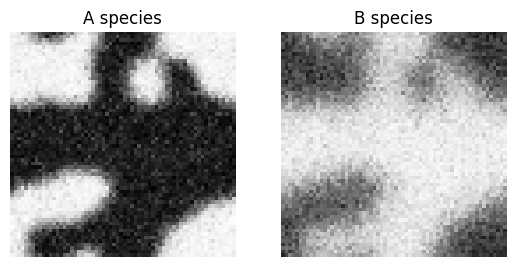

In [10]:
print(ref_state.shape)
fig, axs = plt.subplots(1,2)
axs[0].imshow(ref_state[0].cpu(),cmap="Greys",interpolation="nearest",vmin=0,vmax=50)
axs[0].set_title("A species")
axs[0].axis("off")
axs[1].imshow(ref_state[1].cpu(),cmap="Greys",interpolation="nearest",vmin=0,vmax=50)
axs[1].set_title("B species")
axs[1].axis("off")
plt.show()

define a distance function

In [17]:
def loss(X, Y):
    return t.sum((X[:, 0] - Y[:,0])**2 + (X[:, 1] - Y[:,1])**2, dim=(0,1,2))

In [18]:
loss(ref_state.unsqueeze(0), ref_state.unsqueeze(0))

tensor(0., device='cuda:0')

visualize distances for single param variation

100%|██████████| 100/100 [25:02<00:00, 15.02s/it]


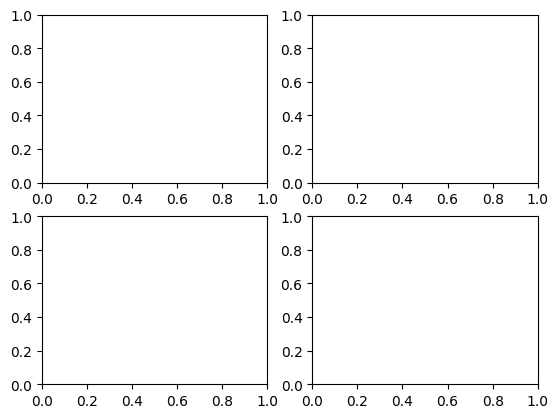

In [43]:
# we use the original DA and DB values
DA = t.tensor(0.1, device=device)
DB = t.tensor(0.4, device=device)
# we use the original rate coefficients for the other reaction channels
k1_bar = t.tensor(0.98, device=device)
k2 = t.tensor(0.1)
k2_bar = t.tensor(0.1, device=device)
k3 = t.tensor(0.2, device=device)
k3_bar = t.tensor(0.2, device=device)
# reaction time constant
gamma = t.tensor(0.005, device=device)
# occupation max. per cell
N = 50

# rate coefficient range
k1_vals = t.linspace(0.0001, 0.9999, 100)

# prep
fig, axs = plt.subplots(2,2)
ref_state = ref_state.unsqueeze(0)

distances = []
gradients = []
for k1 in tqdm(k1_vals):
    k1.requires_grad_()
    X = ref_state.detach().clone()
    # we run the system for 10 steps
    for sim_step in range(1000):
        # run the diffusion step
        X = diffuse_STE(X, N, DA, DB)
        # run the reaction step
        X = rho_STE(X, N, gamma, k1, k1_bar, k2, k2_bar, k3, k3_bar)
    #plt.close(fig)
    #fig, axs = plt.subplots(2,2)
    #axs[0,0].imshow(ref_state[0,0].cpu(),cmap="Greys",interpolation="nearest",vmin=0,vmax=50)
    #axs[0,1].imshow(ref_state[0,1].cpu(),cmap="Greys",interpolation="nearest",vmin=0,vmax=50)
    #axs[1,0].imshow(X[0,0].detach().cpu(),cmap="Greys",interpolation="nearest",vmin=0,vmax=50)
    #axs[1,1].imshow(X[0,1].detach().cpu(),cmap="Greys",interpolation="nearest",vmin=0,vmax=50)
    #plt.show()
    # get the loss
    dist_val = loss(ref_state, X)
    distances.append(dist_val.detach().cpu().numpy())
    # get the gradient w.r.t. the distance
    grad_k1 = t.autograd.grad(dist_val, k1)[0]
    gradients.append(grad_k1.detach().cpu().numpy())

In [42]:
ref_state = ref_state.squeeze()

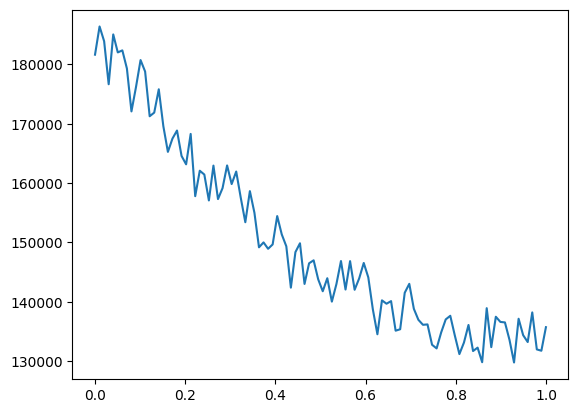

In [44]:
plt.plot(k1_vals.cpu(), distances)

visualize distances for multi-param variation

In [102]:
num_param_steps = 25

DA_vals = t.linspace(0,0.5,num_param_steps, device=device)
DB_vals = t.linspace(0,0.5,num_param_steps, device=device)
k1_vals = t.linspace(0.5,1,num_param_steps, device=device)

mesh_DA, mesh_DB, mesh_k1 = t.meshgrid(DA_vals, DB_vals, k1_vals)

if ref_state.ndim == 3:
    ref_state = ref_state.unsqueeze(0)

distances = np.zeros((num_param_steps, num_param_steps, num_param_steps))
with t.no_grad():
    for DA_idx in range(num_param_steps):
        for DB_idx in tqdm(range(num_param_steps)):
            for k1_idx in range(num_param_steps):
                # init params
                DA = mesh_DA[DA_idx,DB_idx,k1_idx]
                DB = mesh_DB[DA_idx,DB_idx,k1_idx]
                k1 = mesh_k1[DA_idx,DB_idx,k1_idx]
                X = ref_state.detach().clone()
                
                # run simulation
                for i in range(1000):
                    X = diffuse_STE(X, N, DA, DB)
                    X = rho_STE(X, N, gamma, k1, k1_bar, k2, k2_bar, k3, k3_bar)
                
                # calculate the loss
                distance = loss(X, ref_state)
                distances[DA_idx,DB_idx,k1_idx] = distance.detach().cpu().numpy()
            
            

100%|██████████| 25/25 [1:03:00<00:00, 151.24s/it]


In [103]:
np.save("distances_ex_9.npy", distances)

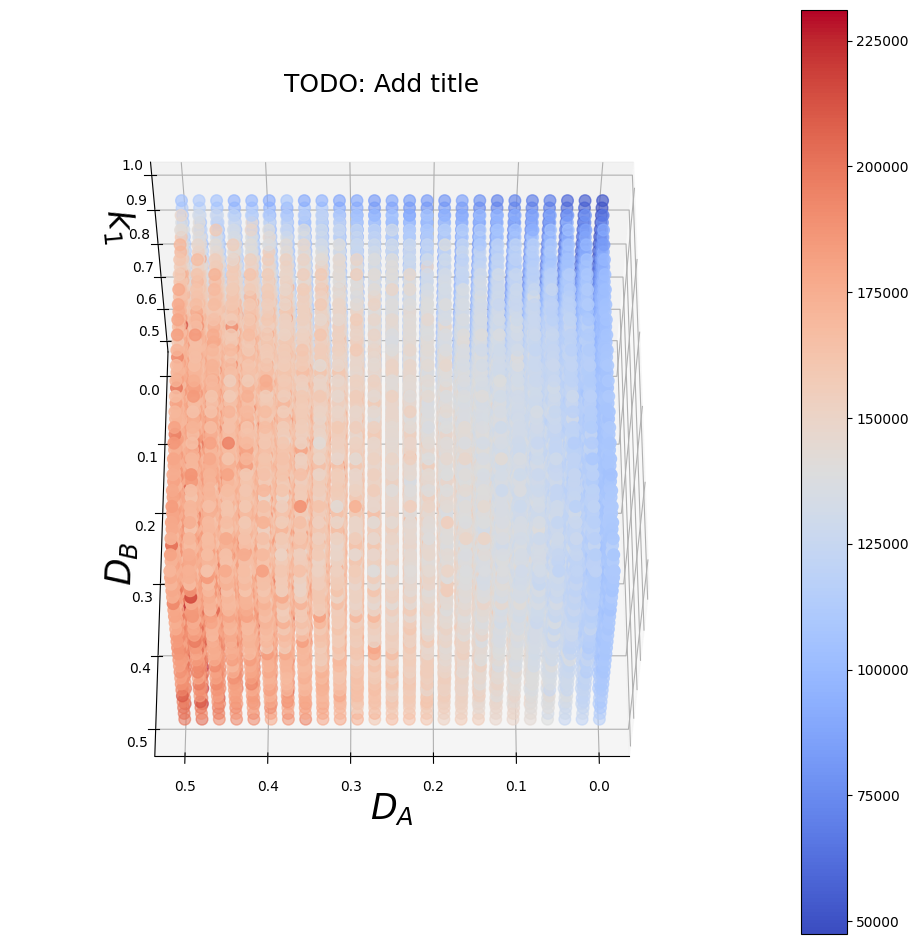

<Figure size 640x480 with 0 Axes>

In [109]:
import matplotlib
import matplotlib.cm as cmx
from matplotlib import rcParams

fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(12,12))

p = ax.scatter(mesh_DA.cpu(),
           mesh_DB.cpu(),
           mesh_k1.cpu(),
           c=distances,
           cmap=cmx.coolwarm,
           s=70)


plt.colorbar(p)

ax.set_xlabel('$D_A$', fontsize=25)
ax.set_ylabel('$D_B$', fontsize=25, rotation=10)
ax.set_zlabel('$k_1$', fontsize=25, rotation=0)

ax.view_init(60, 90)

plt.title("TODO: Add title", fontsize=18)
plt.figure(constrained_layout=True)
plt.show()

visualize distances for multi-param variation (k1, k2, k3)

In [114]:
num_param_steps = 15

k1_vals = t.linspace(0.7,1,num_param_steps, device=device)
k2_vals = t.linspace(0,0.25,num_param_steps, device=device)
k3_vals = t.linspace(0,0.25,num_param_steps, device=device)

mesh_k1, mesh_k2, mesh_k3 = t.meshgrid(k1_vals, k2_vals, k3_vals)

if ref_state.ndim == 3:
    ref_state = ref_state.unsqueeze(0)
    
DA = t.tensor(0.1, device=device)
DB = t.tensor(0.4, device=device)

distances = np.zeros((num_param_steps, num_param_steps, num_param_steps))
with t.no_grad():
    for k1_idx in range(num_param_steps):
        for k2_idx in tqdm(range(num_param_steps)):
            for k3_idx in range(num_param_steps):
                # init params
                k1 = k1_bar = mesh_k1[k1_idx,k2_idx,k3_idx]
                k2 = k2_bar = mesh_k2[k1_idx,k2_idx,k3_idx]
                k3 = k3_bar = mesh_k3[k1_idx,k2_idx,k3_idx]
                X = ref_state.detach().clone()
                
                # run simulation
                for i in range(1000):
                    X = diffuse_STE(X, N, DA, DB)
                    X = rho_STE(X, N, gamma, k1, k1_bar, k2, k2_bar, k3, k3_bar)
                
                # calculate the loss
                distance = loss(X, ref_state)
                distances[k1_idx,k2_idx,k3_idx] = distance.detach().cpu().numpy()
            
            

100%|██████████| 15/15 [20:53<00:00, 83.57s/it]


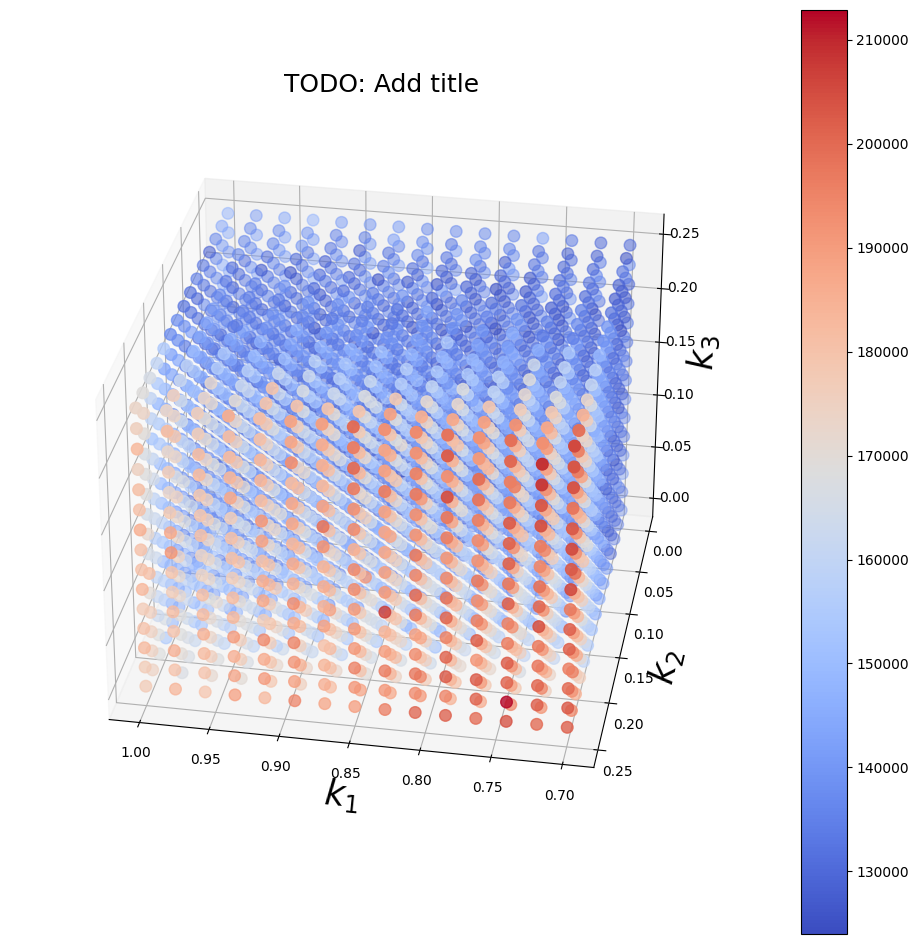

<Figure size 640x480 with 0 Axes>

In [121]:
import matplotlib
import matplotlib.cm as cmx
from matplotlib import rcParams

fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(12,12))

p = ax.scatter(mesh_k1.cpu(),
           mesh_k2.cpu(),
           mesh_k3.cpu(),
           c=distances,
           cmap=cmx.coolwarm,
           s=70)


plt.colorbar(p)

ax.set_xlabel('$k_1$', fontsize=25)
ax.set_ylabel('$k_2$', fontsize=25, rotation=10)
ax.set_zlabel('$k_3$', fontsize=25, rotation=0)

ax.view_init(30, 100)

plt.title("TODO: Add title", fontsize=18)
plt.figure(constrained_layout=True)
plt.show()

In [122]:
np.save("distances_ex9_2.npy", distances)

vis

In [123]:
num_param_steps = 15

k1_vals = t.linspace(0.5,1,num_param_steps, device=device)
k2_vals = t.linspace(0,0.5,num_param_steps, device=device)
k3_vals = t.linspace(0,0.5,num_param_steps, device=device)

mesh_k1, mesh_k2, mesh_k3 = t.meshgrid(k1_vals, k2_vals, k3_vals)

if ref_state.ndim == 3:
    ref_state = ref_state.unsqueeze(0)
    
DA = t.tensor(0.1, device=device)
DB = t.tensor(0.4, device=device)

distances = np.zeros((num_param_steps, num_param_steps, num_param_steps))
with t.no_grad():
    for k1_idx in range(num_param_steps):
        for k2_idx in tqdm(range(num_param_steps)):
            for k3_idx in range(num_param_steps):
                # init params
                k1 = k1_bar = mesh_k1[k1_idx,k2_idx,k3_idx]
                k2 = k2_bar = mesh_k2[k1_idx,k2_idx,k3_idx]
                k3 = k3_bar = mesh_k3[k1_idx,k2_idx,k3_idx]
                X = ref_state.detach().clone()
                
                # run simulation
                for i in range(1000):
                    X = diffuse_STE(X, N, DA, DB)
                    X = rho_STE(X, N, gamma, k1, k1_bar, k2, k2_bar, k3, k3_bar)
                
                # calculate the loss
                distance = loss(X, ref_state)
                distances[k1_idx,k2_idx,k3_idx] = distance.detach().cpu().numpy()
            
            

100%|██████████| 15/15 [20:07<00:00, 80.53s/it]


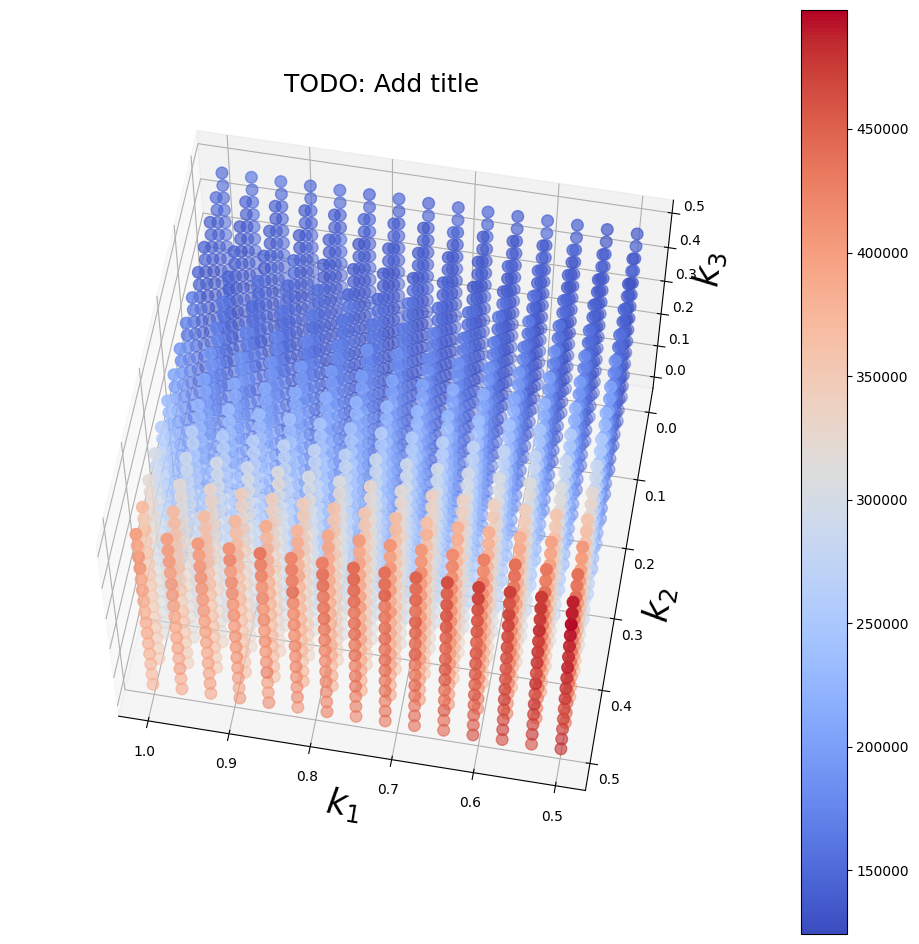

<Figure size 640x480 with 0 Axes>

In [127]:
import matplotlib
import matplotlib.cm as cmx
from matplotlib import rcParams

fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(12,12))

p = ax.scatter(mesh_k1.cpu(),
           mesh_k2.cpu(),
           mesh_k3.cpu(),
           c=distances,
           cmap=cmx.coolwarm,
           s=70)


plt.colorbar(p)

ax.set_xlabel('$k_1$', fontsize=25)
ax.set_ylabel('$k_2$', fontsize=25, rotation=10)
ax.set_zlabel('$k_3$', fontsize=25, rotation=0)

ax.view_init(60, 100)

plt.title("TODO: Add title", fontsize=18)
plt.figure(constrained_layout=True)
plt.show()

In [128]:
np.save("distances_ex9_3.npy", distances)